# Quantum Fourier transformation with hierarcqal


In [1]:
import sys
sys.path.append('c:\\Users\\Amy\\Desktop\\Green_Git\\hierarqcal')

In [2]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from hierarqcal import (
    Qinit,
    Qmask,
    Qunitary,
    Qpivot,
)

## Specify backend
It is possible to use the package without a specific backend, but we choose one here for visualisation purposes. We're mainly going to use the backends plotting functionality to display the circuits, so pick the one you have installed.

In [3]:
backend = "qiskit"

### Some backend dependant helper functions

In [4]:
if backend == "qiskit":
    import qiskit
    from hierarqcal.qiskit.qiskit_circuits import V2, U2, V4

    def get_circuit(hierq):
        return hierq(backend="qiskit")

    def draw_circuit(circuit, **kwargs):
        return circuit.draw(output="mpl", **kwargs)

elif backend == "cirq":
    import cirq
    from cirq.contrib.svg import SVGCircuit
    from hierarqcal.cirq.cirq_circuits import V2, U2, V4
    import logging
    logging.getLogger('matplotlib.font_manager').disabled = True
    def get_circuit(hierq):
        return hierq(backend="cirq")

    def draw_circuit(circuit, **kwargs):
        return SVGCircuit(circuit, **kwargs)

elif backend == "pennylane":
    import pennylane as qml
    from hierarqcal.pennylane.pennylane_circuits import V2, U2, V4

    def get_circuit(hierq):
        dev = qml.device("default.qubit", wires=hierq.tail.Q)

        @qml.qnode(dev)
        def circuit():
            if isinstance(next(hierq.get_symbols(), False), sp.Symbol):
                # Pennylane doesn't support symbolic parameters, so if no symbols were set (i.e. they are still symbolic), we initialize them randomly
                hierq.set_symbols(np.random.uniform(0, 2 * np.pi, hierq.n_symbols))
            hierq(
                backend="pennylane"
            )  # This executes the compute graph in order
            return [qml.expval(qml.PauliZ(wire)) for wire in hierq.tail.Q]

        return circuit

    def draw_circuit(circuit, **kwargs):
        fig, ax = qml.draw_mpl(circuit)(**kwargs)

## Background
Below is a brief description of the discreet Fourier transformation with a sort description of its quantum generalization the quantum Fourier transform or QFT.

### Discrete Fourier transformation
For an input vector $\vec{x}$, the $k$ th element of the transformed vector is given by
$$y_k = \frac{1}{\sqrt{N}} \sum^{N-1}_{j=0} x_j e^{2\pi ijk/N}\,.$$

Generalizing this to a set of state $|0\rangle, |1\rangle, \dots |N-1\rangle$ we have
$$|j\rangle \rightarrow \frac{1}{\sqrt{N}} \sum^{N-1}_{k=0} e^{2\pi ijk/N}|k\rangle\,,$$
so that the Quantum Fourier transform for an arbitrary state with coefficients $\{x_i\}_{i=0}^{N-1}$ is given by
$$\sum_{j=0}^{N-1} x_j |j\rangle \rightarrow \frac{1}{\sqrt{N}}  \sum^{N-1}_{k=0} \sum_{j=0}^{N-1} x_j e^{2\pi ijk/N}|k\rangle =   \sum^{N-1}_{k=0} y_k|k\rangle\,.$$

Assuming we have $n$ qubits is it possible to encode $N=2^n$ states and it is straightforward to check that 
$$|j\rangle \rightarrow  \frac{1}{2^{\frac{n}{2}}} \sum^{N-1}_{k=0} e^{2\pi ijk/2^{n}}|k\rangle = \frac{1}{2^{\frac{n}{2}}} \otimes^{n}_{l=1} \left[|0\rangle+ e^{2\pi ij2^{-l}}|1\rangle \right] = \frac{1}{2^{\frac{n}{2}}} (|0\rangle+ e^{2\pi i 0.j_n}|1\rangle )(|0\rangle+ e^{2\pi i 0.j_{n-1}j_n}|1\rangle)\dots(|0\rangle+ e^{2\pi i 0.j_1j_2\dots j_n}|1\rangle)\,,$$
where $j_1j_2\dots j_n$ represents the binary number $j_1 2^n + j_{2} 2^{n-1}   + \dots + j_n 2^0 $ and $0.j_1j_2\dots j_n$ represents the binary fraction $j_1/2+j_2/2^2+\dots j_n/2^n$.

See Nielsen, Michael A., and Isaac L. Chuang. ["Quantum computation and quantum information."](https://en.wikipedia.org/wiki/Quantum_Computation_and_Quantum_Information) Chapter 5 for further explanation.

## Choose the number of qubits

In [5]:
n = 5
N = 2^n

## Primitive circuit 
The basic building block of the implementation the quantum Fourier transform (QFT) is the circuit that performs the operation
$$|0\rangle_k \rightarrow |0\rangle_k+ e^{2\pi i 0.j_{k}\dots j_n}|1\rangle_k\,.$$
That is the operation that transforms the $k$ th qubit into a superposition with a relative phase determined by its initial states $j_k$ and the state of all of the subsequent bits $j_i$ for $k \leq i \leq n$.


We can construct a unitary $U_k$ to implement this, where $U_k$ works as follows
$$U_k \otimes^{n}_{i=1} |0\rangle_i = \otimes^{k-1}_{i=1} |0\rangle_i (|0\rangle_k+ e^{2\pi i 0.j_{k}\dots j_n}|1\rangle_k) \otimes^{n}_{i=k+1} |0\rangle_i\,.$$
In order to encode the correct phase $e^{2\pi i 0.j_{k}\dots j_n}$ $U_k$ must consist of a  series of controlled operations of the form
$$  |0\rangle_k \langle 0|_k \otimes|0\rangle_{k+l} \langle 0|_{k+l} +  |1\rangle_k \langle 1|_k\otimes |0\rangle_{k+l} \langle 0|_{k+l} +  |0\rangle_k \langle 0|_k \otimes|1\rangle_{k+l} \langle 1|_{k+l} + e^{2\pi i/2^{l+1}}  |1\rangle_k \langle 1|_k  \otimes|1\rangle_{k+l} \langle 1|_{k+l} $$
that act on the $k$ th and $(k+l)$ th bits. This controlled operation adds the phase $\exp(2\pi i j_{k+l} 2^{-l-1})$, and by applying a sequence of these operations for $n-k\geq l\geq 1$ we can (almost!) achieved the desired total phase 
$$\exp(2\pi i j_k 2^{-1})\exp(2\pi i j_{k+1} 2^{-2})\dots \exp(2\pi i j_n 2^{-(n-k+1)})\,.$$

The only missing phase is $\exp(2\pi i j_{k} 2^{-1})$ which cannot be created in this way since the control and target qubits would both be the $k$ th qubit. Instead note that 
$$  |0\rangle_k + e^{2\pi i/2}  |1\rangle_k = |0\rangle_k  - |1\rangle_k $$
which is nothing other than the Hadamard on $|0\rangle_k$.


## Create the primitive circuit with Qpivot

In [6]:
# Create a Hadamard using Qunitary. 
h = Qunitary("h()^0")
#The hadamard has no parameters so we denote is as h(). '^0' indicates that is acts on the first qubit.

# The controlled phase is given by
c_p = Qunitary("cp(x)^01")
# where 'x' is a parameter we will set later. 
# '^01' indicates that the controlled phase acts on the first and second qubits.

In [7]:
# Qpivot automatically creates the sequence of controlled phase gates we need
U_pivot =  Qpivot(mapping=h) + Qpivot(mapping=c_p, share_weights=False)
# since the parameter of the controlled phase are different at each step, share_weights is set to False

In [8]:
# Choose a 0 < k < n+1
k = 2

# Initialise n qubits, mask the previous k-1 qubits and add the pivot sequence
U_k = Qinit(n) + Qmask("1"*(k-1)+"*") + U_pivot
# the string "1"*(k-1)+"*" indicates the qubits we want to mask with a 1,
# and using the wildcard '*' to indicate the remaining unmasked qubits

In [9]:
# create the circuit using the chose backend
circuit= U_k(backend=backend)

In [10]:
# Set the parameters of the circuit using the assign_parameters method
# The parameters are set to be 2*pi*2^(-i-2) where i is the index of the controlled phase
params = {}
i = 0
for p in circuit.parameters:
    params[p] = 2*np.pi*2**(-(i+2))
    i += 1

## TODO fix for other libraries!
circuit = circuit.assign_parameters(params)

## Visualize the primitive circuit

Change the value of k to convince yourself that is indeed works as intended.

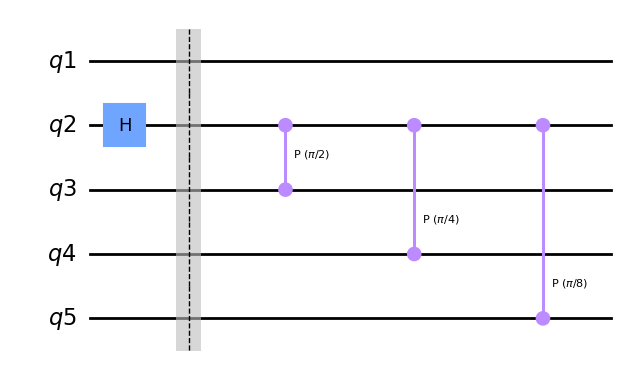

In [11]:
circuit.draw("mpl")

## QFT structure in one line!

In [12]:
qft = (
    Qinit(n)
    + (
        Qpivot(mapping=Qunitary("h()^0"))
        + Qpivot(mapping=Qunitary("cp(x)^01"), share_weights=False)
        + Qmask("1*")
    )
    * n
)

In [13]:
circuit= qft(backend=backend)

In [14]:
circuit= qft(backend=backend)

# We can set the parameters of the circuit using the assign_parameters method
# We set the parameters to be 2*pi*2^(-i-2) where i is the index of the controlled phase
params = {}
count = 0
i = 0
for p in circuit.parameters:
    params[p] = 2*np.pi*2**(-(i+2))
    i+=1
    if i == n-1-count:
        count += 1
        i = 0

## TODO fix for other libraries!
circuit = circuit.assign_parameters(params)

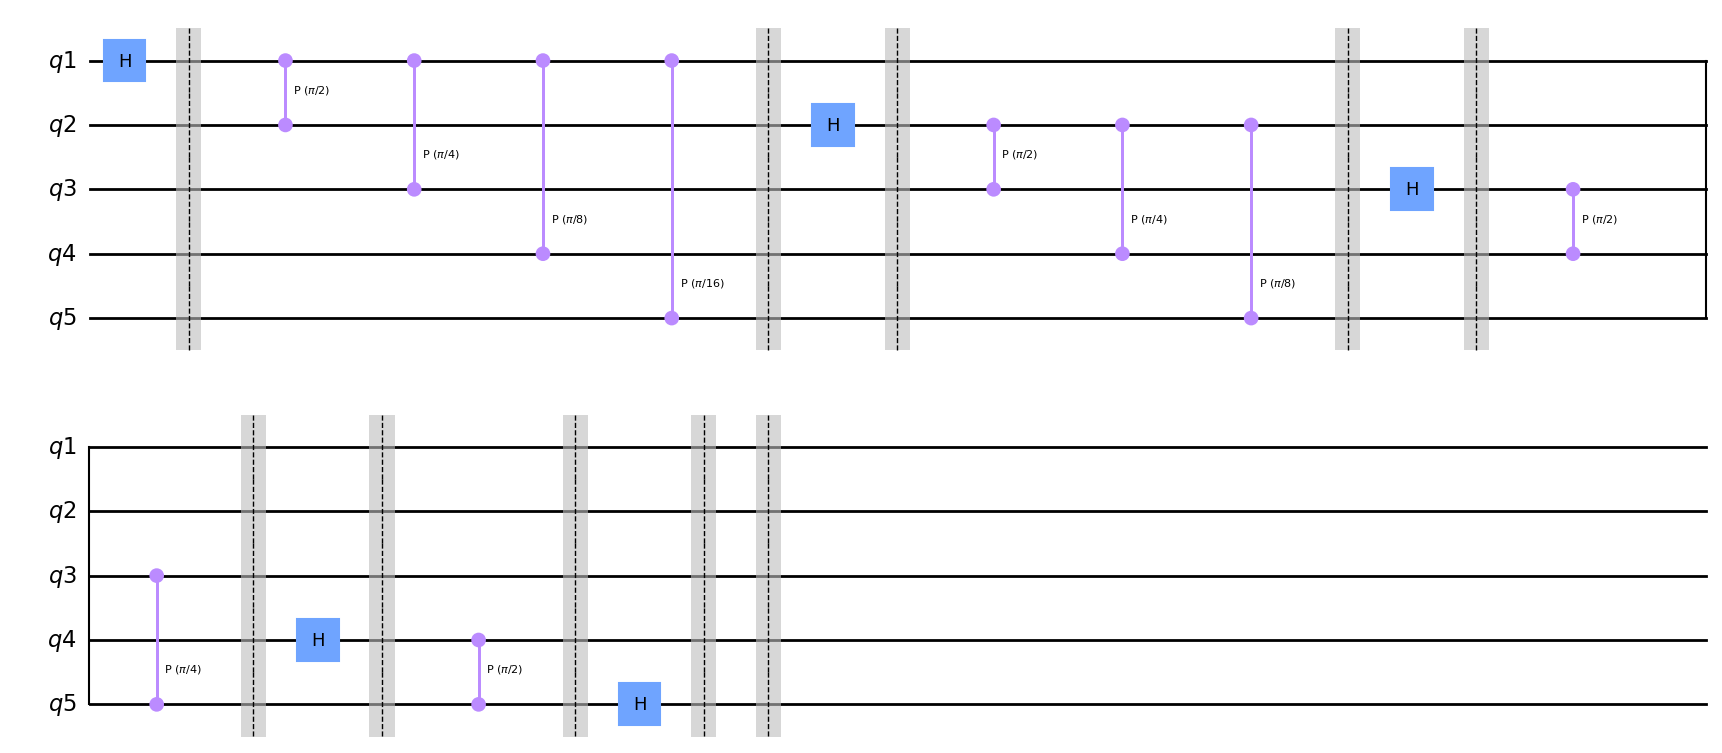

In [15]:
circuit.draw("mpl")

## Does this perform as intended?

It turns out that the circuit transforms the state $|0\rangle$ (understood as all qubits in state $|0\rangle$) to the state
$$\frac{1}{2^{\frac{n}{2}}} (|0\rangle+ e^{2\pi i 0.j_1j_2\dots j_n}|1\rangle) \dots (|0\rangle+ e^{2\pi i 0.j_{n-1}j_n}|1\rangle) (|0\rangle+ e^{2\pi i 0.j_n}|1\rangle )\,.$$ 
You may notice that in fact the order of the qubits is reversed compared to the theoretical QFT described earlier. This can be fixed by performing a series of "swap" operation. 

For simplicity we can assume that the user is aware that they should in fact read all output bit strings in reverse. (Note that Qiskitreadouts form the bottom to the top of the circuit, so this is  automatically taken care of if you are using the Qiskit library.) 

## Experiments

Zero intial state, equal superposition, random state -> compare to fft